# Make your own model
This notebook is used as a showcase of the basic functionality of nlmod. It downloads data, runs a groundwater model and visualizes some of the in- and output. Feel free to change some of the input-variables, for example the model domain (extent) or the simulation period (time).

This notebook builds a model using open data in the Netherlands. The parameters of the model are not calibrated in any way. Therefore, the model probably does not resemble reality very well.

In [1]:
# imports
from packaging.version import Version
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import flopy
import nlmod
!pip install bottleneck

In [2]:
!pip install folium

In [3]:
# do a version check first
logger = nlmod.util.get_color_logger("INFO")

logger.info(f'Current version of nlmod is {nlmod.__version__}')
if not Version(nlmod.__version__) >= Version('0.5.2'):
    logger.warning('This notebook was made for nlmod version 0.5.2. Please update nlmod first.')

INFO:root:Current version of nlmod is 0.6.0


In [4]:
# basic setting

# set extent: [xmin, xmax, ymin, ymax]
# extent = [148_000, 149_000, 393_000, 394_000]  # somewhere in Noord-Brabant
# extent = [94_500, 96_500, 484_000, 485_000]  # somewhere along the coast
# extent = [120_000, 122_000, 486_000, 488_000]  # the centre of Amsterdam
# extent = [100_000, 101_000, 370_000, 371_000]  # in Belgium (needs to give Exception)
extent = [107_850, 111_750, 537_550, 542_050]  # somewhere in Zeeuws-Vlaanderen

dx = extent[1] - extent[0]
dy = extent[3] - extent[2]
# if dx > 2000 or dy > 2000:
#     msg = f"Model size is {dx} by {dy} meter. Please choose a smaller extent, as you will overload this workshop"
#     raise (Exception(msg))

## Download MODFLOW executables
nlmod does not contain the MODFLOW executable. We need to download the latest executable to the bin-directory of nlmod, if we run a model with nlmod for the first time.

In [5]:
if not nlmod.util.check_presence_mfbinaries():
    nlmod.util.download_mfbinaries()

## Download data
We download data from the internet about REGIS, the digintal terrain model (ahn), Basisregistratie Grootschalige Topografie (bgt) and data of the water boards: level areas (la) and watercourses (wc).

In [6]:
logger.info("Downloading data")
regis = nlmod.read.get_regis(extent)

ahn = nlmod.read.ahn.get_ahn4(extent)

bgt = nlmod.read.bgt.get_bgt(extent)

la = nlmod.gwf.download_level_areas(bgt, extent=extent, raise_exceptions=False)

wc = nlmod.gwf.download_watercourses(bgt, extent=extent, raise_exceptions=False)

INFO:root:Downloading data


INFO:nlmod.gwf.surface_water:Downloading level_areas for Hollands Noorderkwartier
INFO:nlmod.gwf.surface_water:Downloading watercourses for Hollands Noorderkwartier


In [7]:
la_new = pd.read_csv('new_areas.csv')

In [8]:
new_la_df = gpd.geoseries.from_wkt(la_new.WKT.values)
new_la_df[0]

NameError: name 'gpd' is not defined

In [ ]:
la_new['geometry'] = new_la_df
la_new.geometry[0]

In [ ]:
df_la = la['Hollands Noorderkwartier'].copy()

In [ ]:
la[0]

## Combine surface water data
We combine the polygon-data of the Basisregistratie Grootschalige Topografie (BGT) with data about the surface level height (ahn) and data of the water boards: level areas (la) and watercourses (wc). We determine a stage and a bottom height (rbot) for ewach of the polygons.

In [9]:
# add information from ahn to bgt
bgt = nlmod.gwf.surface_water.add_min_ahn_to_gdf(bgt, ahn, buffer=5.0)

# add information from level areas (la) to bgt
bgt = nlmod.gwf.surface_water.add_stages_from_waterboards(bgt, la)

# add information from watercources (wc) to bgt
bgt = nlmod.gwf.surface_water.add_bottom_height_from_waterboards(bgt, wc)

# determine stage and rbot of surface water
bgt["stage"] = bgt[["winter_stage", "summer_stage"]].mean(1)
# set a mean sea level of 0.0 m NAP (when sea is in the model)
bgt.loc[bgt["class"] == "zee", "stage"] = 0.0
# when no stage is defined, set the stage to the minimum surface height
mask = bgt["stage"].isna()
bgt.loc[mask, "stage"] = bgt.loc[mask, "ahn_min"]

# rbot determines in which layer the drain is added
bgt["rbot"] = bgt["bottom_height"]
# when stage is below rbot, increase stage to rbot
mask = bgt["stage"] < bgt["rbot"]
bgt.loc[mask, "stage"] = bgt.loc[mask, "rbot"]
# when no bottom height is known, assume a water depth of 0,5 meter
mask = bgt["rbot"].isna()
bgt.loc[mask, "rbot"] = bgt.loc[mask, "stage"] - 0.5

Adding ['summer_stage', 'winter_stage'] from Hollands Noorderkwartier: 100%|████████| 755/755 [00:02<00:00, 287.30it/s]
Adding ['bottom_height'] from Hollands Noorderkwartier: 100%|███████████████████████| 755/755 [00:01<00:00, 404.84it/s]


## Plot some input-data

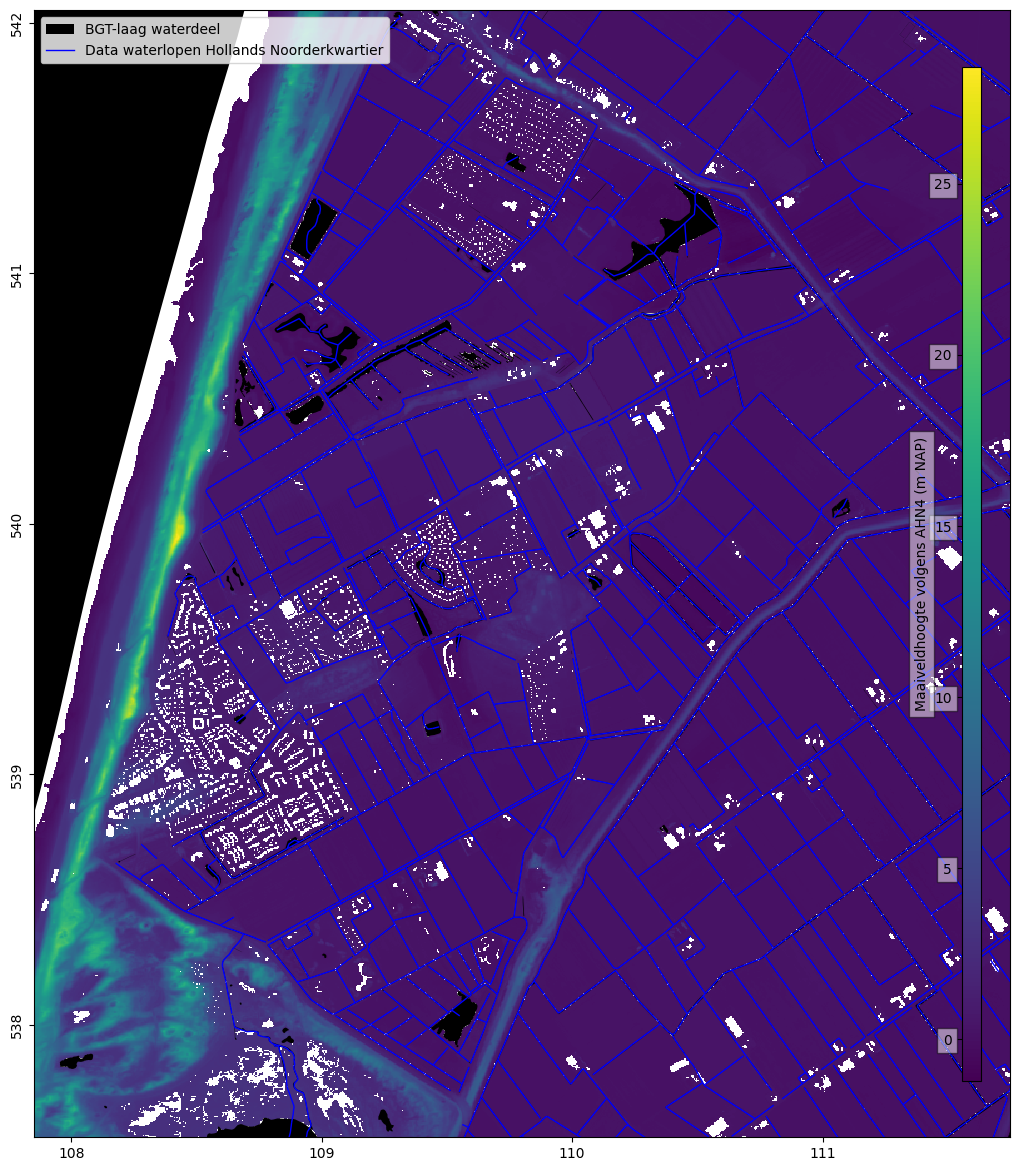

In [10]:
# plot a map with surface water bodies
f, ax = nlmod.plot.get_map(extent)
qm = nlmod.plot.data_array(ahn, ax=ax)
nlmod.plot.colorbar_inside(qm, label="Maaiveldhoogte volgens AHN4 (m NAP)")
handles = []
bgt.plot(ax=ax, color="k")
handles.append(matplotlib.patches.Patch(facecolor="k", label="BGT-laag waterdeel"))
for wb in wc:
    wc[wb].plot(ax=ax, color="b", linewidth=1)
    label = f"Data waterlopen {wb}"
    handles.append(matplotlib.lines.Line2D([], [], color="b", linewidth=1, label=label))
ax.legend(handles=handles, loc=2);

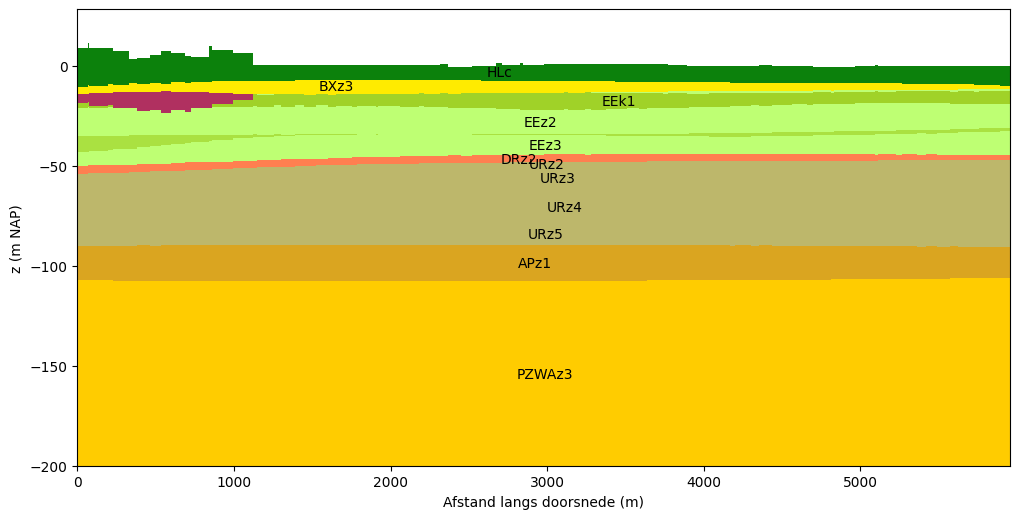

In [11]:
# plot a cross-section through regis
f, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('Afstand langs doorsnede (m)')
ax.set_ylabel('z (m NAP)')
# define a line from southwest to northeast
sw = (extent[0], extent[2])
ne = (extent[1], extent[3])
line = [sw, ne]
dcs = nlmod.plot.dcs.DatasetCrossSection(regis, line, zmin=-200, zmax=float(ahn.max()))
dcs.plot_layers(nlmod.read.regis.get_legend(), min_label_area=10000)
f.tight_layout(pad=0.0)

## Start a model Dataset
We add most of the grid-data to a model Dataset, which is an xarray Dataset. We add grid-refinement (opionally), change the model top and download KNMI-data.

In [12]:
model_name = "nhv_dag"
model_ws = os.path.join("model", model_name)
ds = nlmod.to_model_ds(regis, delr=50, model_name=model_name, model_ws=model_ws)

if True:
    # refine model
    ds = nlmod.grid.refine(ds, refinement_features=[(bgt, 1)])

if True:
    # calculate a finer top from ahn
    top = nlmod.resample.structured_da_to_ds(ahn, ds)
    # when top is NaN, keep the original top
    top = top.where(~top.isnull(), ds["top"])
    # set the new top
    ds = nlmod.layers.set_model_top(ds, top)

if False:
    # set starting head to surface level (instead of 0.0)
    strt = np.repeat(ds["top"].data[np.newaxis, :], len(ds.layer), 0)
    ds["starting_head"] = ds["botm"].dims, strt

# set time dimension
time = pd.date_range("2017", "2023", freq="SMS")
ds = nlmod.time.set_ds_time(ds, time)

# download knmi-data to determine recharge
ds.update(nlmod.read.knmi.get_recharge(ds, cachedir=ds.cachedir, cachename="knmi.nc"))

INFO:nlmod.dims.base:resample layer model data to structured modelgrid
INFO:nlmod.dims.layers:kv and kh both undefined in layer HLc
INFO:nlmod.dims.layers:Filling 41386 values in active cells of kh by multipying kv by an anisotropy of 10
INFO:nlmod.dims.layers:Filling 150065 values in active cells of kv by dividing kh by an anisotropy of 10
INFO:nlmod.dims.layers:Filling 7020 values in active cells of kh with a value of 1.0 m/day
INFO:nlmod.dims.layers:Filling 7020 values in active cells of kv with a value of 0.1 m/day
INFO:nlmod.dims.grid:create vertex grid using gridgen
INFO:nlmod.dims.grid:resample model Dataset to vertex modelgrid
INFO:nlmod.dims.resample:No crs in ds. Setting crs equal to da: EPSG:28992
INFO:nlmod.cache:using cached data -> knmi.nc


<xarray.Dataset>
Dimensions:   (icell2d: 18942, layer: 36, iv: 21101, icv: 9, time: 145)
Coordinates:
  * layer     (layer) object 'HLc' 'BXz2' 'BXk1' 'BXz3' ... 'OOz2' 'OOc' 'BRk1'
    x         (icell2d) float64 1.079e+05 1.079e+05 ... 1.117e+05 1.117e+05
    y         (icell2d) float64 5.42e+05 5.42e+05 ... 5.376e+05 5.376e+05
  * time      (time) datetime64[ns] 2017-01-01 2017-01-15 ... 2023-01-01
Dimensions without coordinates: icell2d, iv, icv
Data variables:
    top       (icell2d) float64 -1.0 -1.0 -1.0 -1.0 ... 1.123 1.306 1.432 0.8589
    botm      (layer, icell2d) float64 -8.12 -8.12 -8.12 ... -711.5 -711.5
    kh        (layer, icell2d) float32 1.0 1.0 1.0 1.0 ... 0.02 0.02 0.02 0.02
    kv        (layer, icell2d) float32 0.1 0.1 0.1 0.1 ... 0.002 0.002 0.002
    idomain   (layer, icell2d) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    area      (icell2d) float32 625.0 625.0 625.0 625.0 ... 625.0 625.0 625.0
    xv        (iv) float64 1.078e+05 1.079e+05 1.079e+05 ... 1.117e+05 1.118e+05
    yv        (iv) float64 5.42e+05 5.42e+05 5.42e+05 ... 5.376e+05 5.376e+05
    icvert    (icell2d, icv) int32 0 1 2 3 0 -1 -1 ... 21099 21097 -1 -1 -1 -1
    recharge  (time, icell2d) float64 0.0005226 0.0005226 ... 0.003453 0.003453
Attributes:
    extent:                    [107850, 111750, 537550, 542050]
    gridtype:                  vertex
    delr:                      50
    delc:                      50
    model_name:                nhv_dag
    mfversion:                 mf6
    model_dataset_created_on:  20230615_15:28:51
    exe_name:                  C:\Users\anne-\anaconda3\envs\envm1602_groundw...
    model_ws:                  model\nhv_dag
    figdir:                    model\nhv_dag\figure
    cachedir:                  model\nhv_dag\cache
    transport:                 0

## Make a groundwater flow model (gwf)
For FloPy, we create a simulation (sim) and a groundwater flow model (gwf) usinge the method  `nlmod.gwf.ds_to_gwf()`. It adds the basic MODFLOW packages to the simulation (tdis and ims) and the groundwater flow model (dis, npf, ic, oc). If "recharge" is present in DataSet, its add a rch-package as well.

In [13]:
gwf = nlmod.gwf.ds_to_gwf(ds, complexity="moderate", icelltype=0, under_relaxation=False)

# add storage package
sy = 0.2
ss = 1e-05
ss_confined_only = True
if ss_confined_only:
    # use a trick to calculate with a storage coefficient of 1.0 (surface water)
    # when the top layer is fully saturated
    ss = xr.full_like(ds["idomain"], 1e-05, float)
    fal = nlmod.layers.get_first_active_layer(ds)
    ss[fal] = 1.0 / nlmod.layers.calculate_thickness(ds)[fal]
nlmod.gwf.sto(ds, gwf, sy=sy, ss=ss, ss_confined_only=ss_confined_only);

INFO:nlmod.sim.sim:creating modflow SIM
INFO:nlmod.sim.sim:creating modflow TDIS
INFO:nlmod.sim.sim:creating modflow IMS
INFO:nlmod.gwf.gwf:creating modflow GWF
INFO:nlmod.gwf.gwf:creating modflow DISV
INFO:nlmod.gwf.gwf:creating modflow NPF
INFO:nlmod.gwf.gwf:creating modflow IC
INFO:nlmod.gwf.gwf:adding 'starting_head' data array to ds
INFO:nlmod.gwf.gwf:creating modflow OC
INFO:nlmod.gwf.gwf:creating modflow RCH


Building ts packages rch: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.05it/s]


INFO:nlmod.gwf.gwf:creating modflow STO
INFO:nlmod.util:Using user-provided 'ss' and not stored data variable 'ds.idomain'


In [14]:
# split surface water by modelgrid
bgt_grid = nlmod.grid.gdf_to_grid(bgt, ds).set_index("cellid")
# calculate conductance from a resistance of 1.0 days
bgt_grid["cond"] = bgt_grid.area / 1.0

# add surface water as drains
spd = nlmod.gwf.surface_water.build_spd(bgt_grid, "DRN", ds)
flopy.mf6.ModflowGwfdrn(gwf, stress_period_data={0: spd});

Building stress period data DRN: 100%|█████████████████████████████████████████| 12019/12019 [00:02<00:00, 4882.38it/s]


## Run model
We write input-files for MODFLOW 6 and run the model.

In [15]:
nlmod.sim.write_and_run(gwf, ds)

INFO:nlmod.sim.sim:write model dataset to cache
INFO:nlmod.sim.sim:write modflow files to model workspace
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model nhv_dag...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package rch...
    writing package ts_0...
    writing package sto...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 12019 based on size of stress_period_data
INFO:nlmod.sim.sim:run model
FloPy is using the following executable to run the model: C:\Users\anne-\anaconda3\envs\envm1602_groundwater\Lib\site-packages\nlmod\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Apr 12 2023 19:05:25 with

## Plot some output-data

In [16]:
# read heads and determine gxg
head = nlmod.gwf.get_heads_da(ds)
gxg = nlmod.gwf.calculate_gxg(head)

In [17]:
# note how selecting one variable allowed for multiple time steps in a single raster



#ds.heads.rio.to_raster("head_low.tif")


ds_hlc = ds.heads[:, 0]
#ds_hlc.rio.to_raster("head_low.tif")

gxg

AttributeError: 'Dataset' object has no attribute 'heads'

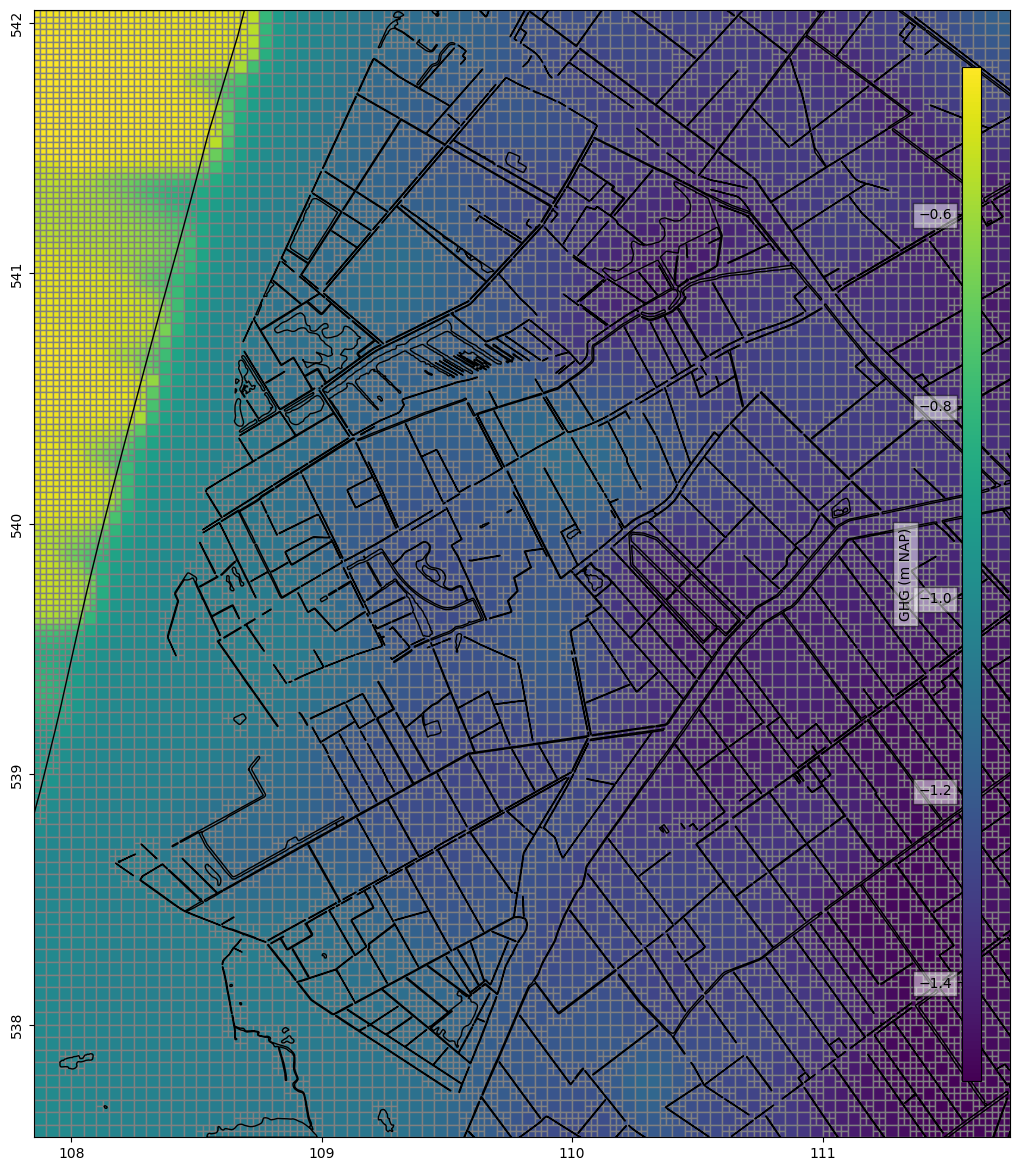

In [18]:
# plot ghg of the first active layer
f, ax = nlmod.plot.get_map(extent)
fal = nlmod.layers.get_first_active_layer(ds)
qm = nlmod.plot.data_array(gxg["glg"][fal], ds=ds, edgecolor="grey")
bgt.plot(ax=ax, linewidth=1, edgecolor="k", facecolor="none")
nlmod.plot.colorbar_inside(qm, label="GHG (m NAP)");

In [30]:
ds.to_netcdf('ds_current.nc')

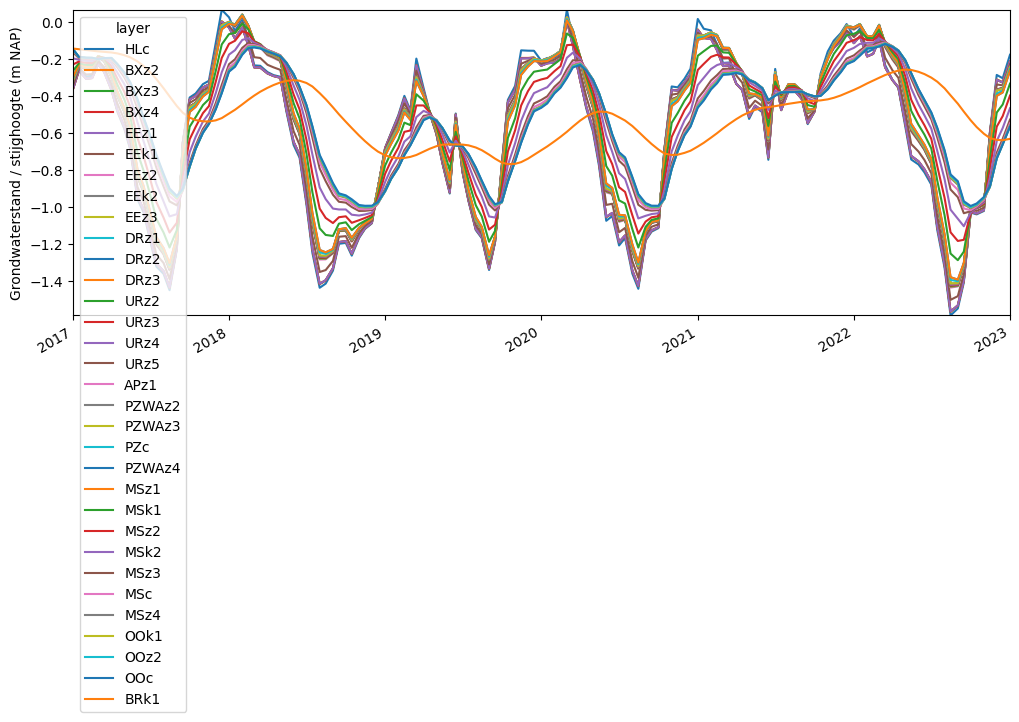

In [27]:
# plot the head at a certain point in several layers
x = 109409.4 # np.mean([extent[0], extent[1]])

y = 541660.3 # np.mean([extent[2], extent[3]])
head_point = nlmod.gwf.get_head_at_point(head, x, y, ds=ds)
f, ax = plt.subplots(figsize=(10, 6))
head_point.to_pandas().plot(ax=ax)
ax.autoscale(tight=True)
ax.set_ylabel('Grondwaterstand / stijghoogte (m NAP)')
ax.set_xlabel('')
f.tight_layout(pad=0.0)

In [26]:
h_top_former = head_point[:,0]
np.savetxt('h_top_former.txt', h_top_former)

## Compare with measurements

In [ ]:
# download measurements
import hydropandas as hpd

fname_pklz = os.path.join(ds.cachedir, 'oc_bro.pklz')
if os.path.exists(fname_pklz):
    oc = pd.read_pickle(fname_pklz)
else:
    oc = hpd.read_bro(extent=ds.extent, name='BRO', tmin=ds.time.values.min(), tmax=ds.time.values.max(), )
    oc.to_pickle(fname_pklz)


# get modellayers
oc['modellayer'] = oc.gwobs.get_modellayers(ds=ds)

# get modelled head at measurement points
ds['heads'] = nlmod.gwf.get_heads_da(ds)
oc_modflow = hpd.read_modflow(oc, gwf, ds['heads'].values, ds.time.values)

# add modelled head to measured heads
obs_list_map = []
for gld in oc.index:
    o = oc.loc[gld,'obs']
    if o.empty:
        continue
    
    o = o.resample('D').last().sort_index()
    modelled = oc_modflow.loc[gld, 'obs']
    modelled = hpd.GroundwaterObs(modelled.rename(columns={0: 'values'}), name=f'{o.name}_mod_lay{oc.loc[gld,"modellayer"]}', x=o.x, y=o.y, 
                                  tube_nr=o.tube_nr+1,screen_top=o.screen_top, screen_bottom=o.screen_bottom, 
                                  tube_top=o.tube_top, monitoring_well=o.monitoring_well, source='MODFLOW', unit= 'm NAP',
                                  ground_level=o.ground_level, metadata_available=o.metadata_available)
    obs_list_map.append(o)
    obs_list_map.append(modelled)

oc_map = hpd.ObsCollection.from_list(obs_list_map, name='meting+model')

# c#create interactive map
oc_map.plots.interactive_map(os.path.join(ds.figdir, 'iplots'))

#### Exercise 10

In the cells above change the extent to a place in the Netherlands you would like to model. Run the model and check the results. Try to see which processes are missing or modelled incorrectly. Think about how you can improve this.

Note: this functionality of nlmod has not been tested thoroughly so there is a big chance you will encounter errors that are hard to solve, sorry for that :)

In [ ]:
obs_list_map

In [ ]:
pd.read_pickle(fname_pklz)